## Facial Emotion facial expression classifer for 7 classes
                    AF = afraid
					AN = angry
					DI = disgusted
					HA = happy
					NE = neutral
					SA = sad
					SU = surprised

Dataset
- Information http://www.emotionlab.se/kdef/
- Download dataset http://kdef.se/download/KDEF_and_AKDEF.zip

Image File naming convention:

        Letter 1: Session 
                    A = series one
                    B = series two
        Letter 2: Gender 
                    F = female
                    M = male
        Letter 3 & 4: Identity number
                    01 - 35
        Letter 5 & 6: Expression
                    AF = afraid
                    AN = angry
                    DI = disgusted
                    HA = happy
                    NE = neutral
                    SA = sad
                    SU = surprised
        Letter 7 & 8: Angle
                    FL = full left profile
                    HL = half left profile
                    S = straight
                    HR = half right profile
                    FR = full right profile

In [42]:
%reload_ext autoreload
%matplotlib inline
%autoreload 2

In [43]:
from fastai import *
from fastai.vision import *

In [44]:
torch.cuda.device_count()

1

In [45]:
path=Path('data/KDEF_and_AKDEF')
src_data_dir=Path('data/KDEF_and_AKDEF')
flat_dir=Path('data/KDEF_and_AKDEF/flat')


#path=Path('/home/user/git/data/bears')
#torch.cuda.set_device(1)

In [46]:
if not os.listdir(flat_dir):
    src_dir = src_data_dir/"KDEF"
    for x in src_dir.iterdir():
        for lnk_src in x.iterdir():
            lnk_dst = flat_dir.joinpath(lnk_src.name)
            os.link(lnk_src, lnk_dst)
    # Some files are misnamed, so fix them manually here
    rename_dict = {
        'AF31V': 'AF31SAHL',
        'AM31H': 'AM31SUHR',
    }
    for frm in rename_dict:
        to = rename_dict[frm]
        os.rename(flat_dir/(frm + ".JPG"), flat_dir/(to + ".JPG"))

### Create ImageDataBunch and take a quick look at the data
- There is no separate validation set, so set aside 20% as validation data set.


In [47]:
emotion_dict={
    'AF' : 'afraid',
    'AN' : 'angry',
    'DI' : 'disgusted',
    'HA' : 'happy',
    'NE' : 'neutral',
    'SA' : 'sad', 
    'SU' : 'surprised'    
}
fnames = get_image_files(flat_dir, check_ext=False)
pat = r'/\w{4}(\w{2})\w{1,2}\.JPG$'
import re
codes = set()
for fn in fnames:
    res = re.search(pat, fn.as_posix())
    code = emotion_dict[res.group(1)]
    codes.add(code)
codes

{'afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised'}

In [50]:
np.random.seed(42)
bs=256

In [51]:
pat = r'/\w{4}(\w{2})\w{1,2}\.JPG$'
import re

def getClass(fname):
    res = re.search(pat, fname.as_posix())
    code = emotion_dict[res.group(1)]
    return code

['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']
training size: 3920 validate size: 980


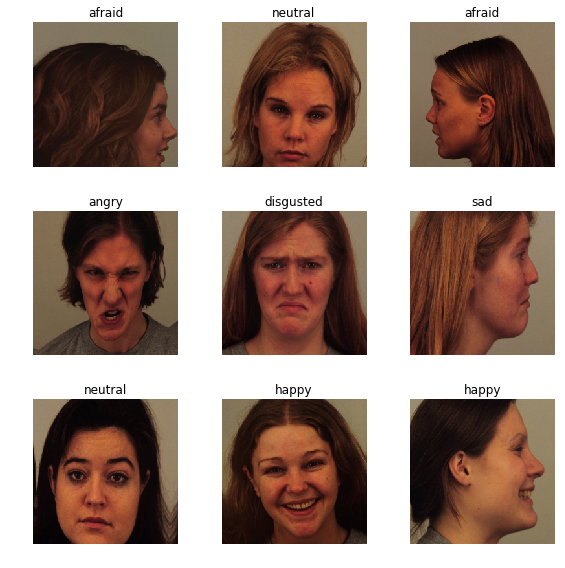

In [76]:
#tfms = get_transforms(max_zoom=1, max_warp=None)
#tfms = get_transforms(max_zoom=1.1, max_rotate=5, max_warp=None)
tfms = get_transforms()
data = ImageDataBunch.from_name_func(flat_dir, fnames, getClass, ds_tfms=tfms, size=224, bs=16).normalize(imagenet_stats)
#data.show_batch(rows=3, figsize=(8,8))
print(data.classes)
print('training size: %s validate size: %s' %(len(data.train_ds), len(data.valid_ds)))
data.show_batch(rows=3, figsize=(8,8))

### Train Model
1. Usually you should use lr_finder first to find the learning rate. (default is 3e-3)
2. Train it first without unfreeze.
3. Unfreeze it and give differential learning rates and train again.
4. Do some data clean up and re-train again.

In [77]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [78]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate
1,1.921173,1.582250,0.623469
2,1.580335,1.296572,0.504082
3,1.355566,1.067337,0.407143
4,1.207242,0.967221,0.355102
5,1.107343,0.956233,0.341837


In [66]:
learn.save('stage-1')

In [67]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (3920 items)
[Category disgusted, Category happy, Category neutral, Category sad, Category sad]...
Path: data/KDEF_and_AKDEF/flat
x: ImageItemList (3920 items)
[Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562)]...
Path: data/KDEF_and_AKDEF/flat;

Valid: LabelList
y: CategoryList (980 items)
[Category neutral, Category afraid, Category neutral, Category surprised, Category happy]...
Path: data/KDEF_and_AKDEF/flat
x: ImageItemList (980 items)
[Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562)]...
Path: data/KDEF_and_AKDEF/flat;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padd

In [79]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


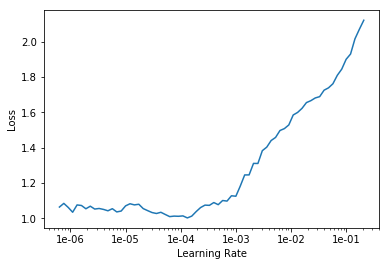

In [69]:

learn.lr_find()
learn.recorder.plot()

In [80]:
learn.fit_one_cycle(10,max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate
1,1.049071,0.829465,0.304082
2,0.889693,0.638047,0.218367
3,0.706712,0.525744,0.178571
4,0.563904,0.394932,0.139796
5,0.460039,0.314439,0.120408
6,0.429241,0.311237,0.113265
7,0.350912,0.259868,0.094898
8,0.311445,0.238285,0.079592
9,0.283594,0.237880,0.071429
10,0.250755,0.226479,0.070408


In [81]:
learn.save('stage-2')

In [82]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (3920 items)
[Category angry, Category disgusted, Category afraid, Category angry, Category neutral]...
Path: data/KDEF_and_AKDEF/flat
x: ImageItemList (3920 items)
[Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562)]...
Path: data/KDEF_and_AKDEF/flat;

Valid: LabelList
y: CategoryList (980 items)
[Category surprised, Category sad, Category neutral, Category disgusted, Category sad]...
Path: data/KDEF_and_AKDEF/flat
x: ImageItemList (980 items)
[Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562)]...
Path: data/KDEF_and_AKDEF/flat;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, pa

### Interpretation

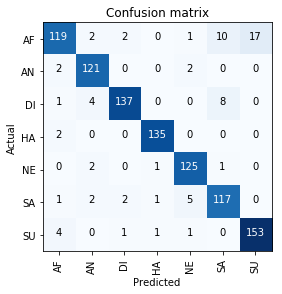

In [35]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Data Clean up and then do the re-train

In [8]:
from fastai.widgets import *

In [9]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [18]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

### Inference

In [36]:
classes = ['AF', 'AN', 'DI', 'HA', 'NE', 'SA', 'SU']
data2 = ImageDataBunch.single_from_classes(flat_dir, classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)
learn = create_cnn(data2, models.resnet34)
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (0 items)
[]...
Path: data/KDEF_and_AKDEF/flat
x: ImageItemList (0 items)
[]...
Path: data/KDEF_and_AKDEF/flat;

Valid: LabelList
y: CategoryList (0 items)
[]...
Path: data/KDEF_and_AKDEF/flat
x: ImageItemList (0 items)
[]...
Path: data/KDEF_and_AKDEF/flat;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

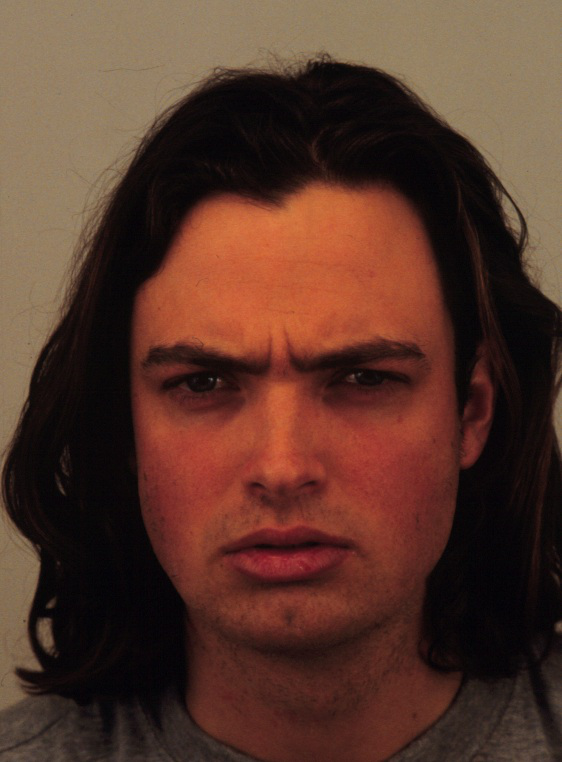

In [83]:
img = open_image(flat_dir/'AM01ANS.JPG')
#img = open_image(path/'teddys'/'00000021.jpg')
#img = open_image(path/'grizzly'/'00000021.jpg')
img

In [84]:
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class,pred_idx,outputs)

angry tensor(1) tensor([3.1078e-03, 9.6678e-01, 2.0115e-02, 5.8037e-04, 2.3618e-03, 6.7245e-03,
        3.2789e-04])


### Flask Web API to do the inference

In [ ]:
#Flask Web site
from servefastai import serve
serve(learn)

 * Serving Flask app "servefastai" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:9999/ (Press CTRL+C to quit)
127.0.0.1 - - [01/Jan/2019 20:20:35] "GET / HTTP/1.1" 200 -


## Test Code

In [1]:
from notebook.auth import passwd
passwd()

Enter password: ········
Verify password: ········


'sha1:13f20fce2676:5f388033b2df5ada9140adb045c06b2d6bb238d2'